# Проект 3. Решить задачу DaNetQA / BoolQ

Можно решить как задачу для русского, так и для английского.

Либо провести эксперименты с многоязычной моделью

https://russiansuperglue.com/ru/tasks/task_info/DaNetQA

## Описание
Причинно-следственная связь, логический вывод, Natural Language Inference

DaNetQA - это набор да/нет вопросов с ответами и фрагментом текста, содержащим ответ. Все вопросы были написаны авторами без каких-либо искусственных ограничений.

Каждый пример представляет собой триплет (вопрос, фрагмент текста, ответ) с заголовком страницы в качестве необязательного дополнительного контекста.

Настройка классификации текстовых пар аналогична существующим задачам логического вывода (NLI)

### Тип задачи
Логика, Commonsense, Знания о мире. Бинарная классификация: true/false

## Notebook prepeares

In [2]:
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.5 MB/s eta 0:00:00a 0:00:010m


In [16]:
__COLAB_ACTIVE = False

import matplotlib.pyplot as plt
#from sklearn.metrics import accuracy_score
import os

base_path = os.path.abspath('')
if __COLAB_ACTIVE:
    from google.colab import drive
    drive.mount('/content/drive')
    base_path = os.path.join(base_path, 'drive/MyDrive/DSnML_Innopolis2022')

print(f"Root path: '{base_path}'")

trainPartNameRaw = 'train_L0'
testPartNameRaw =  'test_L0'
validatePartNameRaw = 'val_L0'

trainPartNameL1 = 'train_L1'
testPartNameL1 = 'test_L1' 
validatePartNameL1 = 'val_L1'
data_path = os.path.join(base_path, 'DaNetQA')
print(f"Dataset path: {data_path}")

def fileNameData(s):
    return f"{os.path.join(data_path, s)}.jsonl"

Root path: '/home/leysh/git_repos/DSnML_Innopolis2022/00_Final_Attestation'
Dataset path: /home/leysh/git_repos/DSnML_Innopolis2022/00_Final_Attestation/DaNetQA


# Исследование данных

In [9]:
import pandas as pd
import numpy as np
import unicodedata

In [10]:
import nltk
from nltk.stem.snowball import SnowballStemmer 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/leysh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Utils/Class

In [43]:
def loadJSONL(path, name = ""):
    df = pd.read_json(path, lines=True)
    if len(name) > 0:
        print(name)
        display(df.head())
    if (df.columns.values == 'label').any():
        s = np.unique(df['label'].to_numpy(), return_counts=True)[1]
        if len(name) > 0:
            print(f"True answer: {s[1]}")
            print(f"False answer: {s[0]}")
            print("")
    return df

In [22]:
class DataCleaner:
    def __init__(self) -> None:
        self.flag_verbose = True

        self.stop_words = stopwords.words('russian')
        self.stemmer = SnowballStemmer('russian')

        self.count_removed_symbols = dict()
        self.count_removed_words = dict()

        self.count_replaced_symbols = dict()
        self.dict_replaced_symbols = dict()

        self.count_replaced_words = dict()
        self.dict_replaced_words = dict()

        self.char_to_remove = ['«', '»', '—', ',', '.', '-', '/', ':', '!', "?", "(", ")", "{", "}", "[", "]", "@", "#", "$", "%", "^", "&", "*", "=", "|", "\\", ">", "<"]
        self.char_to_replace = [['ё', 'е']]

    # функция подсчета количества измененных слов
    def addReplacedWord(self, s_from, s_to = ' '):
        if not self.count_replaced_words.keys().__contains__(s_from):
            self.count_replaced_words[s_from] = 0
        self.count_replaced_words[s_from] += 1
        self.dict_replaced_words[s_from] = s_to

    # функция подсчета количества удаленных слов
    def addRemovedWord(self, w):
        if w == ' ':
            if not self.count_removed_symbols.keys().__contains__(w):
                self.count_removed_symbols[w] = 0
            self.count_removed_symbols[w] += 1

    # функция подсчета количества удаленных символов
    def addReplacedSymbol(self, s_from, s_to = ' '):
        if s_to == ' ':
            if not self.count_removed_symbols.keys().__contains__(s_from):
                self.count_removed_symbols[s_from] = 0
            self.count_removed_symbols[s_from] += 1
        else:
            if not self.count_replaced_symbols.keys().__contains__(s_from):
                self.count_replaced_symbols[s_from] = 0
            self.count_replaced_symbols[s_from] += 1
            self.dict_replaced_symbols[s_from] = s_to

    # удаление знаков ударения и прочих символов unicode
    def unicodeToAscii(self, s):
        tmp = []
        for c in unicodedata.normalize('NFD', s):
            if unicodedata.category(c) != 'Mn':
                tmp.append(c)
            else:
                self.addReplacedSymbol(c)
        return ''.join(tmp)

    # если нужно удалить, то заменяем на пробел чтоб не потерят разделения слов
    def replaceChar(self, s):
        tmp = []
        for i, c in enumerate(s):
            if self.char_to_remove.__contains__(c):
                self.addReplacedSymbol(c, s[i])
                tmp.append(' ')
            else:
                tmp.append(c)
        s = "".join(tmp)

        for s_from, s_to in self.char_to_replace:
            if c == s_from:
                s[i] = s_to
                self.addReplacedSymbol(s_from, s_to)
        return s

    # удаляем лишние пробелы
    def trimSpaces(self, s):
        while s.__contains__('  '):
            s = s.replace('  ', ' ')
        s = s.strip()
        return s

    # удаляем слва из stopwords
    def removeStopWords(self, s):
        tmp = []
        for word in word_tokenize(s):
            if word not in self.stop_words:
                tmp.append(word)
            else:
                self.addRemovedWord(word)
        return " ".join(tmp)

    # удаляем слва из stopwords
    def StemmWords(self, s):
        tmp = []
        for word in word_tokenize(s):
            wordStemmed = self.stemmer.stem(word)
            tmp.append(wordStemmed)
            if word != wordStemmed:
                self.addReplacedWord(word, wordStemmed)
        return " ".join(tmp)

    # основная функция для процессинга
    def clean(self, df, column, level):
        for i in range(len(df)):
            # L1 удаляем только юникод
            if level > 0:
                df[column][i] = self.unicodeToAscii(df[column][i])
            # L2 переводим в нижний регистр
            if level > 1:
                df[column][i] = df[column][i].lower()
            # L3 удаляем символы пунктуации и тд
            if level > 2:
                df[column][i] = self.replaceChar(df[column][i])
            # L4 удаляем стоп слова
            if level > 3:
                df[column][i] = self.removeStopWords(df[column][i])
            # L5 леммитизация
            if level > 4:
                df[column][i] = self.StemmWords(df[column][i])
            
            # удаляем пробелы
            df[column][i] = self.trimSpaces(df[column][i])
        return df

    # прокси для выключения вывода на экран summary
    def print(self, vals):
        if self.flag_verbose == True:
            print(vals)

    # прокси для выключения вывода на экран summary
    def display(self, vals):
            if self.flag_verbose == True:
                display(vals)

    # сбор лога в dataframe, опциональный вывод на экран 
    def summary(self, verbose = True):
        self.flag_verbose = verbose
        dfs = dict()

        cols = ["symbol", "count_removed"]
        dfRemoved = pd.DataFrame(columns=cols)
        if len(self.count_removed_symbols) > 0:
            self.print("===================================")
            self.print("===        Removed Chars        ===")
            self.print("===================================")
            for c in self.count_removed_symbols:
                current_df = pd.DataFrame([[c, self.count_removed_symbols[c]]], columns=cols) 
                dfRemoved = pd.concat([dfRemoved, current_df], ignore_index=True)
            self.display(dfRemoved)
        dfs['Removed Chars'] = dfRemoved

                
        cols = ["word", "count_removed"]
        dfRemoved = pd.DataFrame(columns=cols)
        if len(self.count_removed_words) > 0:
            self.print("===================================")
            self.print("===        Removed Words        ===")
            self.print("===================================")
            for c in self.count_removed_words:
                current_df = pd.DataFrame([[c, self.count_removed_words[c]]], columns=cols) 
                dfRemoved = pd.concat([dfRemoved, current_df], ignore_index=True)
            self.display(dfRemoved)
        dfs['Removed Words'] = dfRemoved

                
        cols = ["symbol_from", "symbol_to", "count_replaced"]
        dfRemoved = pd.DataFrame(columns=cols)
        if len(self.dict_replaced_symbols) > 0:
            self.print("===================================")
            self.print("===        Replaced Chars       ===")
            self.print("===================================")
            for c in self.dict_replaced_symbols:
                current_df = pd.DataFrame([[ c, self.dict_replaced_symbols[c], self.count_replaced_symbols[c]]], columns=cols) 
                dfRemoved = pd.concat([dfRemoved, current_df], ignore_index=True)
            self.display(dfRemoved)
        dfs['Replaced Chars'] = dfRemoved

                
        cols = ["word_from", "word_to", "count_replaced"]
        dfRemoved = pd.DataFrame(columns=cols)
        if len(self.dict_replaced_symbols) > 0:
            self.print("===================================")
            self.print("===        Stemmed Words        ===")
            self.print("===================================")
            for c in self.dict_replaced_words:
                current_df = pd.DataFrame([[ c, self.dict_replaced_words[c], self.count_replaced_words[c]]], columns=cols) 
                dfRemoved = pd.concat([dfRemoved, current_df], ignore_index=True)
            self.display(dfRemoved)
        dfs['Stemmed Words'] = dfRemoved


        return dfs

## Обрабатываем данные

In [39]:
df_train = loadJSONL(fileNameData(trainPartNameRaw))
df_validation = loadJSONL(fileNameData(validatePartNameRaw))
df_test = loadJSONL(fileNameData(testPartNameRaw))

cleanLog = dict()

for iL in range(1, 6):
    cleaner = DataCleaner()

    df_train = cleaner.clean(df_train, 'passage', 1)
    df_test = cleaner.clean(df_test, 'passage', 1)
    df_validation = cleaner.clean(df_validation, 'passage', 1)
    df_train = cleaner.clean(df_train, 'question', 1)
    df_test = cleaner.clean(df_test, 'question', 1)
    df_validation = cleaner.clean(df_validation, 'question', 1)

    cleanLog[iL] = cleaner.summary(False)
    df_train.to_json(fileNameData(f"train_L{iL}"), lines=True, orient='records')
    df_test.to_json(fileNameData(f"test_L{iL}"), lines=True, orient='records')
    df_validation.to_json(fileNameData(f"val_L{iL}"), lines=True, orient='records')

/tmp/ipykernel_17275/1867449280.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column][i] = self.unicodeToAscii(df[column][i])
/tmp/ipykernel_17275/1867449280.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column][i] = self.trimSpaces(df[column][i])


ValueError: 'lines' keyword only valid when 'orient' is records

In [ ]:
df_train = loadJSONL(fileNameData(trainPartNameRaw), "Train set")
df_validation = loadJSONL(fileNameData(validatePartNameRaw), "Validation set")
df_test = loadJSONL(fileNameData(testPartNameRaw), "Test set:")

In [1]:
import logging
from pathlib import Path
from typing import List, Mapping, Tuple

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import yaml
from catalyst.utils import set_global_seed, prepare_cudnn
from transformers import AutoTokenizer, AutoConfig, AutoModel
from catalyst.callbacks.metrics.accuracy import AccuracyCallback
from catalyst.dl import (
    CheckpointCallback,
    OptimizerCallback,
    SchedulerCallback,
    SupervisedRunner,
)

/home/leysh/miniconda3/envs/catalyst1/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_project_root() -> Path:
    return Path("").parent.parent

# Data Load

In [3]:
class TextClassificationDataset(Dataset):
    """
    Wrapper around Torch Dataset to perform text classification
    """

    def __init__(
        self,
        texts: List[str],
        questions: List[str],
        labels: List[str] = None,
        label_dict: Mapping[str, int] = None,
        max_seq_length: int = None,
        model_name: str = None,
    ):
        """
        Args:
            texts (List[str]): a list with texts to classify or to train the
                classifier on
            labels List[str]: a list with classification labels (optional)
            label_dict (dict): a dictionary mapping class names to class ids,
                to be passed to the validation data (optional)
            max_seq_length (int): maximal sequence length in tokens,
                texts will be stripped to this length
            model_name (str): transformer model name, needed to perform
                appropriate tokenization

        """

        self.texts = texts
        self.questions = questions
        self.labels = labels
        self.label_dict = label_dict
        self.max_seq_length = max_seq_length

        if self.label_dict is None and labels is not None:
            # {'class1': 0, 'class2': 1, 'class3': 2, ...}
            # using this instead of `sklearn.preprocessing.LabelEncoder`
            # no easily handle unknown target values
            self.label_dict = dict(zip(sorted(set(labels)), range(len(set(labels)))))

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        # suppresses tokenizer warnings
        logging.getLogger("transformers.tokenization_utils").setLevel(logging.FATAL)

        # special tokens for transformers
        # in the simplest case a [CLS] token is added in the beginning
        # and [SEP] token is added in the end of a piece of text
        # [CLS] <indexes text tokens> [SEP] .. <[PAD]>
        self.sep_label = self.tokenizer.special_tokens_map['sep_token']
        self.sep_vid = self.tokenizer.vocab[self.sep_label]
        self.cls_label = self.tokenizer.special_tokens_map['cls_token']
        self.cls_vid = self.tokenizer.vocab[self.cls_label]
        self.pad_label = self.tokenizer.special_tokens_map['pad_token']
        self.pad_vid = self.tokenizer.vocab[self.pad_label]

    def __len__(self) -> int:
        """
        Returns:
            int: length of the dataset
        """
        return len(self.texts)

    def __getitem__(self, index) -> Mapping[str, torch.Tensor]:
        """Gets element of the dataset

        Args:
            index (int): index of the element in the dataset
        Returns:
            Single element by index
        """
        # encoding the text
        x = self.texts[index] + self.sep_label + self.questions[index]

        # a dictionary with `input_ids` and `attention_mask` as keys
        output_dict = self.tokenizer.encode_plus(
            text=x,
            ##text_pair=text_pair, 
            ##text_target=text_target, 
            ##text_pair_target=text_pair_target, 
            add_special_tokens=True,
            #  Pad to a maximum length specified with the argument max_length
            #  or to the maximum acceptable input length for the model if that argument is not provided.
            padding="max_length", 
            # Truncate to a maximum length specified with the argument max_length 
            # or to the maximum acceptable input length for the model if that argument is not provided. 
            # This will truncate token by token, 
            # removing a token from the longest sequence in the pair if a pair of sequences (or a batch of pairs) is provided.
            truncation=True,
            # Controls the maximum length to use by one of the truncation/padding parameters.
            max_length=self.max_seq_length, 
            # return pytorch tensor
            return_tensors="pt", 
            return_token_type_ids=True,
            return_attention_mask=True,
        )

        # for Catalyst, there needs to be a key called features
        output_dict["features"] = output_dict["input_ids"].squeeze(0)
        del output_dict["input_ids"]

        # encoding target
        if self.labels is not None:
            y = self.labels[index]
            y_encoded = torch.Tensor([self.label_dict.get(y, -1)]).long().squeeze(0)
            output_dict["targets"] = y_encoded
            
        return output_dict

In [4]:
class TextClassificationDataset(Dataset):
    """
    Wrapper around Torch Dataset to perform text classification
    """

    def __init__(
        self,
        texts: List[str],
        questions: List[str],
        labels: List[str] = None,
        label_dict: Mapping[str, int] = None,
        max_seq_length: int = None,
        model_name: str = None,
    ):
        """
        Args:
            texts (List[str]): a list with texts to classify or to train the
                classifier on
            labels List[str]: a list with classification labels (optional)
            label_dict (dict): a dictionary mapping class names to class ids,
                to be passed to the validation data (optional)
            max_seq_length (int): maximal sequence length in tokens,
                texts will be stripped to this length
            model_name (str): transformer model name, needed to perform
                appropriate tokenization

        """

        self.texts = texts
        self.questions = questions
        self.labels = labels
        self.label_dict = label_dict
        self.max_seq_length = max_seq_length

        if self.label_dict is None and labels is not None:
            # {'class1': 0, 'class2': 1, 'class3': 2, ...}
            # using this instead of `sklearn.preprocessing.LabelEncoder`
            # no easily handle unknown target values
            self.label_dict = dict(zip(sorted(set(labels)), range(len(set(labels)))))

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        # suppresses tokenizer warnings
        logging.getLogger("transformers.tokenization_utils").setLevel(logging.FATAL)

        # special tokens for transformers
        # in the simplest case a [CLS] token is added in the beginning
        # and [SEP] token is added in the end of a piece of text
        # [CLS] <indexes text tokens> [SEP] .. <[PAD]>
        self.sep_label = self.tokenizer.special_tokens_map['sep_token']
        self.sep_vid = self.tokenizer.vocab[self.sep_label]
        self.cls_label = self.tokenizer.special_tokens_map['cls_token']
        self.cls_vid = self.tokenizer.vocab[self.cls_label]
        self.pad_label = self.tokenizer.special_tokens_map['pad_token']
        self.pad_vid = self.tokenizer.vocab[self.pad_label]

    def __len__(self) -> int:
        """
        Returns:
            int: length of the dataset
        """
        return len(self.texts)

    def __getitem__(self, index) -> Mapping[str, torch.Tensor]:
        """Gets element of the dataset

        Args:
            index (int): index of the element in the dataset
        Returns:
            Single element by index
        """
        # encoding the text
        x = [self.texts[index], self.questions[index]]

        # a dictionary with `input_ids` and `attention_mask` as keys
        output_dict = self.tokenizer.encode_plus(
            text=x,
            ##text_pair=text_pair, 
            ##text_target=text_target, 
            ##text_pair_target=text_pair_target, 
            add_special_tokens=True,
            #  Pad to a maximum length specified with the argument max_length
            #  or to the maximum acceptable input length for the model if that argument is not provided.
            padding="max_length", 
            # Truncate to a maximum length specified with the argument max_length 
            # or to the maximum acceptable input length for the model if that argument is not provided. 
            # This will truncate token by token, 
            # removing a token from the longest sequence in the pair if a pair of sequences (or a batch of pairs) is provided.
            truncation=True,
            # Controls the maximum length to use by one of the truncation/padding parameters.
            max_length=self.max_seq_length, 
            # return pytorch tensor
            return_tensors="pt", 
            return_token_type_ids=True,
            return_attention_mask=True,
        )

        # for Catalyst, there needs to be a key called features
        output_dict["features"] = output_dict["input_ids"].squeeze(0)
        del output_dict["input_ids"]

        output_dict["token_type_ids"] = output_dict["token_type_ids"].squeeze(0)

        # encoding target
        if self.labels is not None:
            y = self.labels[index]
            y_encoded = torch.Tensor([self.label_dict.get(y, -1)]).long().squeeze(0)
            output_dict["targets"] = y_encoded
            
        return output_dict

In [5]:
#train_df = pd.read_json(Path(params["data"]["path_to_data"]) / params["data"]["train_filename"], lines=True)

In [6]:
#quest = train_df.iloc[0][0]
#passage = train_df.iloc[0][1]

In [7]:
#model_name=params["model"]["model_name"]
#tokenizer = AutoTokenizer.from_pretrained(model_name)

In [8]:
def read_data(params: dict) -> Tuple[dict, dict]:
    """
    A custom function that reads data from CSV files, creates PyTorch datasets and
    data loaders. The output is provided to be easily used with Catalyst

    :param params: a dictionary read from the config.yml file
    :return: a tuple with 2 dictionaries
    """
    # reading CSV files to Pandas dataframes
    train_df = pd.read_json(Path(params["data"]["path_to_data"]) / params["data"]["train_filename"], lines=True)
    valid_df = pd.read_json(Path(params["data"]["path_to_data"]) / params["data"]["validation_filename"], lines=True)
    test_df = pd.read_json(Path(params["data"]["path_to_data"]) / params["data"]["test_filename"], lines=True)

    # creating PyTorch Datasets
    
    train_dataset = TextClassificationDataset(
        texts=train_df[params["data"]["text_field_name"]].values.tolist(),
        questions=train_df[params["data"]["quest_field_name"]].values.tolist(),
        labels=train_df[params["data"]["label_field_name"]].values,
        max_seq_length=params["model"]["max_seq_length"],
        model_name=params["model"]["model_name"],
    )

    valid_dataset = TextClassificationDataset(
        texts=valid_df[params["data"]["text_field_name"]].values.tolist(),
        questions=valid_df[params["data"]["quest_field_name"]].values.tolist(),
        labels=valid_df[params["data"]["label_field_name"]].values,
        max_seq_length=params["model"]["max_seq_length"],
        model_name=params["model"]["model_name"],
    )

    test_dataset = TextClassificationDataset(
        texts=test_df[params["data"]["text_field_name"]].values.tolist(),
        questions=test_df[params["data"]["quest_field_name"]].values.tolist(),
        max_seq_length=params["model"]["max_seq_length"],
        model_name=params["model"]["model_name"],
    )

    set_global_seed(params["general"]["seed"])

    # creating PyTorch data loaders and placing them in dictionaries (for Catalyst)
    train_val_loaders = {
        "train": DataLoader(
            dataset=train_dataset,
            batch_size=params["training"]["batch_size"],
            shuffle=True,
        ),
        "valid": DataLoader(
            dataset=valid_dataset,
            batch_size=params["training"]["batch_size"],
            shuffle=False,
        ),
    }

    test_loaders = {
        "test": DataLoader(
            dataset=test_dataset,
            batch_size=params["training"]["batch_size"],
            shuffle=False,
        )
    }

    del train_df
    del valid_df
    del test_df
    del train_dataset
    del valid_dataset
    del test_dataset

    return train_val_loaders, test_loaders


# Model

In [9]:
class BertForSequenceClassification(nn.Module):
    """
    Simplified version of the same class by HuggingFace.
    See transformers/modeling_distilbert.py in the transformers repository.
    """

    def __init__(
        self, 
        pretrained_model_name: str, 
        num_classes: int = None, 
        dropout: float = 0.3
    ):
        """
        Args:
            pretrained_model_name (str): HuggingFace model name.
                See transformers/modeling_auto.py
            num_classes (int): the number of class labels
                in the classification task
        """
        super().__init__()

        config = AutoConfig.from_pretrained(pretrained_model_name, num_labels=num_classes)

        self.model = AutoModel.from_pretrained(pretrained_model_name, config=config)
        self.dropout = nn.Dropout(dropout)

        if 1: #default out-of-box gateway
            self.classifier = nn.Linear(config.hidden_size, num_classes)
        else:
            self.classifier = nn.Linear(config.hidden_size * 2, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, **kwargs):
        attention_mask = kwargs['attention_mask']
        features = kwargs['features']
        token_type_ids = kwargs['token_type_ids']
        head_mask = None
    #def forward(self, features, attention_mask=None, token_type_ids=None, head_mask=None):
        """Compute class probabilities for the input sequence.

        Args:
            features (torch.Tensor): ids of each token,
                size ([bs, seq_length]
            attention_mask (torch.Tensor): binary tensor, used to select
                tokens which are used to compute attention scores
                in the self-attention heads, size [bs, seq_length]
            head_mask (torch.Tensor): 1.0 in head_mask indicates that
                we keep the head, size: [num_heads]
                or [num_hidden_layers x num_heads]
        Returns:
            PyTorch Tensor with predicted class scores
        """
        assert attention_mask is not None, "attention mask is none"

        # taking BERTModel output
        # see https://huggingface.co/transformers/model_doc/bert.html#transformers.BertModel
        bert_output = self.model(
            input_ids=features, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids, 
            head_mask=head_mask)
        # we only need the hidden state here and don't need
        # transformer output, so index 0

        if 1: #default out-of-box gateway
            seq_output = bert_output[0]  # (bs, seq_len, dim)
            # mean pooling, i.e. getting average representation of all tokens
            pooled_output = seq_output.mean(axis=1)  # (bs, dim)
            pooled_output = self.dropout(pooled_output)  # (bs, dim)
            scores = self.classifier(pooled_output)  # (bs, num_classes)
        else:
            encoder_out = bert_output['last_hidden_state']
            
            pooled_output, _ = torch.max(encoder_out, 1)
            pooled_output = torch.relu(pooled_output)
            
            pooled_output_mean = torch.mean(encoder_out, 1)
            #cls = bert_output[:, 0, :]
            pooled_output = torch.cat((pooled_output, pooled_output_mean), 1)
            
            pooled_output = self.dropout(pooled_output)
            scores = self.classifier(pooled_output)
            
            #scores = (logits,) + scores[2:]  # add hidden states and attention if they are here

            #if self.model labels is not None:
            #    if self.num_labels == 1:
            #        # We are doing regression
            #        loss_fct = MSELoss()
            #        loss = loss_fct(logits.view(-1), labels.view(-1))
            #    else:
            #        loss = torch.nn.functional.binary_cross_entropy_with_logits( logits.view(-1), labels.view(-1) )
            #    outputs = (loss,) + outputs
        scores = self.softmax(scores)
        return scores

# Train

In [10]:
# loading config params
project_root: Path = get_project_root()
with open(str(project_root / "config.yml")) as f:
    params = yaml.load(f, Loader=yaml.FullLoader)

In [11]:
# read and process data
train_val_loaders, test_loaders = read_data(params)

In [12]:
# initialize the model
model = BertForSequenceClassification(
    pretrained_model_name=params["model"]["model_name"],
    num_classes=params["model"]["num_classes"],
)

In [13]:
param_optimizer = list(model.model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.0}
]

# specify criterion for the multi-class classification task, optimizer and scheduler
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(optimizer_grouped_parameters, lr=float(params["training"]["learn_rate"]))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [14]:
# specify criterion for the multi-class classification task, optimizer and scheduler
#criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=float(params["training"]["learn_rate"]))
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [15]:
# reproducibility
set_global_seed(params["general"]["seed"])
prepare_cudnn(deterministic=True)

In [16]:
# here we specify that we pass masks to the runner. So model's forward method will be called with
# these arguments passed to it.
runner = SupervisedRunner(input_key=("features", "attention_mask", "token_type_ids"))

In [17]:
# finally, training the model with Catalyst
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=train_val_loaders,
    callbacks=[
        AccuracyCallback(num_classes=int(params["model"]["num_classes"]), input_key="logits", target_key="targets"),
        OptimizerCallback(accumulation_steps=int(params["training"]["accum_steps"]), metric_key="loss"),
        SchedulerCallback(loader_key="valid", metric_key="loss"),
        CheckpointCallback(logdir=params["training"]["log_dir"], loader_key="valid", metric_key="loss", minimize=True),
    ],
    logdir=params["training"]["log_dir"],
    num_epochs=int(params["training"]["num_epochs"]),
    verbose=True,
)

1/40 * Epoch (train): 100%|██████████| 219/219 [00:23<00:00,  9.21it/s, accuracy01=1.000, accuracy03=1.000, loss=0.961, lr=3.000e-05, momentum=0.900]


train (1/40) accuracy01: 0.660377358490566 | accuracy01/std: 0.17373957822883326 | accuracy03: 0.9937106918238994 | accuracy03/std: 0.04006443330218777 | loss: 1.247953957152271 | loss/mean: 1.247953957152271 | loss/std: 0.14766338532704634 | lr: 3e-05 | momentum: 0.9


1/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 28.28it/s, accuracy01=0.200, accuracy03=1.000, loss=1.547, lr=3.000e-05, momentum=0.900]


valid (1/40) accuracy01: 0.5347137637209516 | accuracy01/std: 0.2072192715296685 | accuracy03: 1.0 | accuracy03/std: 0.0 | loss: 1.3519909008702178 | loss/mean: 1.3519909008702178 | loss/std: 0.1718507006992778 | lr: 3e-05 | momentum: 0.9
* Epoch (1/40) lr: 3e-05 | momentum: 0.9


2/40 * Epoch (train): 100%|██████████| 219/219 [00:24<00:00,  8.99it/s, accuracy01=0.600, accuracy03=1.000, loss=1.224, lr=3.000e-05, momentum=0.900]


train (2/40) accuracy01: 0.734133790805723 | accuracy01/std: 0.16142105753342775 | accuracy03: 0.9845626072041167 | accuracy03/std: 0.042840975665180574 | loss: 1.1680994410048635 | loss/mean: 1.1680994410048635 | loss/std: 0.14866473638511085 | lr: 3e-05 | momentum: 0.9


2/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 27.29it/s, accuracy01=0.400, accuracy03=1.000, loss=1.455, lr=3.000e-05, momentum=0.900]


valid (2/40) accuracy01: 0.5590742996708918 | accuracy01/std: 0.1849848262011882 | accuracy03: 0.9975639464068213 | accuracy03/std: 0.01728977890693757 | loss: 1.3390054201818413 | loss/mean: 1.3390054201818413 | loss/std: 0.17511012960974734 | lr: 3e-05 | momentum: 0.9
* Epoch (2/40) lr: 3e-05 | momentum: 0.9


3/40 * Epoch (train): 100%|██████████| 219/219 [00:24<00:00,  8.91it/s, accuracy01=0.600, accuracy03=0.800, loss=1.306, lr=3.000e-05, momentum=0.900]


train (3/40) accuracy01: 0.7821612350595818 | accuracy01/std: 0.14632889526089285 | accuracy03: 0.9897084048368237 | accuracy03/std: 0.03886071519233726 | loss: 1.1235005228501722 | loss/mean: 1.1235005228501722 | loss/std: 0.1385511909366497 | lr: 3e-05 | momentum: 0.9


3/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 27.14it/s, accuracy01=0.600, accuracy03=0.800, loss=1.325, lr=3.000e-05, momentum=0.900]


valid (3/40) accuracy01: 0.5809987821184037 | accuracy01/std: 0.1615986484311394 | accuracy03: 0.9719853837510407 | accuracy03/std: 0.061044404111228565 | loss: 1.3147306985309148 | loss/mean: 1.3147306985309148 | loss/std: 0.14983014438064682 | lr: 3e-05 | momentum: 0.9
* Epoch (3/40) lr: 3e-05 | momentum: 0.9


4/40 * Epoch (train): 100%|██████████| 219/219 [00:24<00:00,  8.88it/s, accuracy01=0.800, accuracy03=0.800, loss=1.105, lr=3.000e-05, momentum=0.900]


train (4/40) accuracy01: 0.8250428816807347 | accuracy01/std: 0.13432201519040676 | accuracy03: 0.946826758181592 | accuracy03/std: 0.08950949635203112 | loss: 1.0784581209196913 | loss/mean: 1.0784581209196913 | loss/std: 0.1279348721639241 | lr: 3e-05 | momentum: 0.9


4/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 27.02it/s, accuracy01=0.600, accuracy03=0.600, loss=1.307, lr=3.000e-05, momentum=0.900]


valid (4/40) accuracy01: 0.582216808914993 | accuracy01/std: 0.19482752038123627 | accuracy03: 0.7600487212170637 | accuracy03/std: 0.14879433347539978 | loss: 1.3195208483869063 | loss/mean: 1.3195208483869063 | loss/std: 0.1877208087730406 | lr: 3e-05 | momentum: 0.9
* Epoch (4/40) lr: 3e-05 | momentum: 0.9


5/40 * Epoch (train): 100%|██████████| 219/219 [00:24<00:00,  8.90it/s, accuracy01=0.800, accuracy03=1.000, loss=1.105, lr=3.000e-05, momentum=0.900]


train (5/40) accuracy01: 0.8502001143851374 | accuracy01/std: 0.12673832470294238 | accuracy03: 0.9559748427672959 | accuracy03/std: 0.06863770376544676 | loss: 1.0553120793173012 | loss/mean: 1.0553120793173012 | loss/std: 0.11949026871618522 | lr: 3e-05 | momentum: 0.9


5/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 27.17it/s, accuracy01=0.600, accuracy03=0.800, loss=1.305, lr=3.000e-05, momentum=0.900]


valid (5/40) accuracy01: 0.5907429964911197 | accuracy01/std: 0.19996843279669393 | accuracy03: 0.7734470159069486 | accuracy03/std: 0.14371442273784119 | loss: 1.3102893507001458 | loss/mean: 1.3102893507001458 | loss/std: 0.1956308879194732 | lr: 3e-05 | momentum: 0.9
* Epoch (5/40) lr: 3e-05 | momentum: 0.9


6/40 * Epoch (train): 100%|██████████| 219/219 [00:24<00:00,  8.90it/s, accuracy01=1.000, accuracy03=1.000, loss=0.905, lr=3.000e-05, momentum=0.900]


train (6/40) accuracy01: 0.8553459119496853 | accuracy01/std: 0.12941851054403378 | accuracy03: 0.9325328759291022 | accuracy03/std: 0.09275493461011927 | loss: 1.050763304639775 | loss/mean: 1.050763304639775 | loss/std: 0.12686896699690586 | lr: 3e-05 | momentum: 0.9


6/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 27.17it/s, accuracy01=0.600, accuracy03=0.600, loss=1.305, lr=3.000e-05, momentum=0.900]


valid (6/40) accuracy01: 0.6333739343717532 | accuracy01/std: 0.17915980805481568 | accuracy03: 0.758830694420474 | accuracy03/std: 0.16116374580454282 | loss: 1.2639723512345198 | loss/mean: 1.2639723512345198 | loss/std: 0.1735101896626448 | lr: 3e-05 | momentum: 0.9
* Epoch (6/40) lr: 3e-05 | momentum: 0.9


7/40 * Epoch (train): 100%|██████████| 219/219 [00:24<00:00,  8.84it/s, accuracy01=1.000, accuracy03=1.000, loss=0.905, lr=3.000e-05, momentum=0.900]


train (7/40) accuracy01: 0.860491709548313 | accuracy01/std: 0.11949545228889655 | accuracy03: 0.9108061749571185 | accuracy03/std: 0.1010125037384226 | loss: 1.043138897677977 | loss/mean: 1.043138897677977 | loss/std: 0.11642023743942209 | lr: 3e-05 | momentum: 0.9


7/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 27.26it/s, accuracy01=0.600, accuracy03=0.600, loss=1.305, lr=3.000e-05, momentum=0.900]


valid (7/40) accuracy01: 0.6406820951512903 | accuracy01/std: 0.17866789609222195 | accuracy03: 0.7576126676238845 | accuracy03/std: 0.15197849972571312 | loss: 1.2626660867672457 | loss/mean: 1.2626660867672457 | loss/std: 0.17545383962412034 | lr: 3e-05 | momentum: 0.9
* Epoch (7/40) lr: 3e-05 | momentum: 0.9


8/40 * Epoch (train): 100%|██████████| 219/219 [00:24<00:00,  8.82it/s, accuracy01=0.600, accuracy03=0.800, loss=1.305, lr=3.000e-05, momentum=0.900]


train (8/40) accuracy01: 0.8724985706799369 | accuracy01/std: 0.11837037339772497 | accuracy03: 0.9331046312519177 | accuracy03/std: 0.0858169844869974 | loss: 1.0307856682984058 | loss/mean: 1.0307856682984058 | loss/std: 0.1137413877598651 | lr: 3e-05 | momentum: 0.9


8/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 27.04it/s, accuracy01=0.400, accuracy03=0.600, loss=1.508, lr=3.000e-05, momentum=0.900]


valid (8/40) accuracy01: 0.6345919610594426 | accuracy01/std: 0.17909865210697862 | accuracy03: 0.7320341048955046 | accuracy03/std: 0.16415899124572544 | loss: 1.2710094645020444 | loss/mean: 1.2710094645020444 | loss/std: 0.17891749659606776 | lr: 3e-05 | momentum: 0.9
* Epoch (8/40) lr: 3e-05 | momentum: 0.9


9/40 * Epoch (train): 100%|██████████| 219/219 [00:24<00:00,  8.77it/s, accuracy01=1.000, accuracy03=1.000, loss=0.906, lr=3.000e-05, momentum=0.900]


train (9/40) accuracy01: 0.8753573470554603 | accuracy01/std: 0.1142779082230332 | accuracy03: 0.9348198970840482 | accuracy03/std: 0.08222961470923766 | loss: 1.030081753051915 | loss/mean: 1.030081753051915 | loss/std: 0.11251449203590115 | lr: 3e-05 | momentum: 0.9


9/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 26.83it/s, accuracy01=0.400, accuracy03=0.600, loss=1.505, lr=3.000e-05, momentum=0.900]


valid (9/40) accuracy01: 0.6065773447378834 | accuracy01/std: 0.17009496030122764 | accuracy03: 0.7734470159795482 | accuracy03/std: 0.15385749228265447 | loss: 1.297197380977775 | loss/mean: 1.297197380977775 | loss/std: 0.16712797637493215 | lr: 3e-05 | momentum: 0.9
* Epoch (9/40) lr: 3e-05 | momentum: 0.9


10/40 * Epoch (train): 100%|██████████| 219/219 [00:24<00:00,  8.80it/s, accuracy01=1.000, accuracy03=1.000, loss=0.906, lr=3.000e-05, momentum=0.900]


train (10/40) accuracy01: 0.8993710691823901 | accuracy01/std: 0.10504795727327916 | accuracy03: 0.9325328759291023 | accuracy03/std: 0.08298934121282925 | loss: 1.006607582870383 | loss/mean: 1.006607582870383 | loss/std: 0.10371376062322149 | lr: 3e-05 | momentum: 0.9


10/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 26.86it/s, accuracy01=0.600, accuracy03=0.600, loss=1.313, lr=3.000e-05, momentum=0.900]


valid (10/40) accuracy01: 0.5919610232877094 | accuracy01/std: 0.18472769265193772 | accuracy03: 0.7040194885739454 | accuracy03/std: 0.16193093854414153 | loss: 1.3129404976365047 | loss/mean: 1.3129404976365047 | loss/std: 0.1811499767002107 | lr: 3e-05 | momentum: 0.9
* Epoch (10/40) lr: 3e-05 | momentum: 0.9


11/40 * Epoch (train): 100%|██████████| 219/219 [00:24<00:00,  8.80it/s, accuracy01=1.000, accuracy03=1.000, loss=0.905, lr=3.000e-05, momentum=0.900]


train (11/40) accuracy01: 0.882218410520297 | accuracy01/std: 0.1082600917423521 | accuracy03: 0.9325328759291023 | accuracy03/std: 0.08719136270163334 | loss: 1.021433539633208 | loss/mean: 1.021433539633208 | loss/std: 0.1058289560089381 | lr: 3e-05 | momentum: 0.9


11/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 26.52it/s, accuracy01=0.400, accuracy03=0.600, loss=1.505, lr=3.000e-05, momentum=0.900]


valid (11/40) accuracy01: 0.6065773447378833 | accuracy01/std: 0.1771195074239992 | accuracy03: 0.7783191231659067 | accuracy03/std: 0.1510293153067213 | loss: 1.298049907881798 | loss/mean: 1.298049907881798 | loss/std: 0.17597527631278997 | lr: 3e-05 | momentum: 0.9
* Epoch (11/40) lr: 3e-05 | momentum: 0.9


12/40 * Epoch (train): 100%|██████████| 219/219 [00:25<00:00,  8.72it/s, accuracy01=0.800, accuracy03=1.000, loss=1.105, lr=3.000e-05, momentum=0.900]


train (12/40) accuracy01: 0.87364208122333 | accuracy01/std: 0.11476994184179663 | accuracy03: 0.9342481417953119 | accuracy03/std: 0.08808779784711528 | loss: 1.0315519533817117 | loss/mean: 1.0315519533817117 | loss/std: 0.11344494831079244 | lr: 3e-05 | momentum: 0.9


12/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 26.94it/s, accuracy01=0.400, accuracy03=0.600, loss=1.505, lr=3.000e-05, momentum=0.900]


valid (12/40) accuracy01: 0.5724725944333767 | accuracy01/std: 0.18639022998280028 | accuracy03: 0.7101096225568931 | accuracy03/std: 0.1544308595303459 | loss: 1.3308165726795265 | loss/mean: 1.3308165726795265 | loss/std: 0.1823414285613564 | lr: 3e-05 | momentum: 0.9
* Epoch (12/40) lr: 3e-05 | momentum: 0.9


13/40 * Epoch (train): 100%|██████████| 219/219 [00:25<00:00,  8.75it/s, accuracy01=1.000, accuracy03=1.000, loss=0.905, lr=3.000e-05, momentum=0.900]


train (13/40) accuracy01: 0.8970840480274441 | accuracy01/std: 0.11339146829862289 | accuracy03: 0.9594053744997137 | accuracy03/std: 0.06970344828890229 | loss: 1.00890098587999 | loss/mean: 1.00890098587999 | loss/std: 0.1128696598614708 | lr: 3e-05 | momentum: 0.9


13/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 26.98it/s, accuracy01=0.400, accuracy03=0.800, loss=1.505, lr=3.000e-05, momentum=0.900]


valid (13/40) accuracy01: 0.5919610231788095 | accuracy01/std: 0.19161363164152018 | accuracy03: 0.7722289891103588 | accuracy03/std: 0.16232615824460644 | loss: 1.3126414732578755 | loss/mean: 1.3126414732578755 | loss/std: 0.19027488975362855 | lr: 3e-05 | momentum: 0.9
* Epoch (13/40) lr: 3e-05 | momentum: 0.9


14/40 * Epoch (train): 100%|██████████| 219/219 [00:25<00:00,  8.75it/s, accuracy01=0.800, accuracy03=0.800, loss=1.105, lr=3.000e-05, momentum=0.900]


train (14/40) accuracy01: 0.8965122927727868 | accuracy01/std: 0.1127428093527729 | accuracy03: 0.9622641509774759 | accuracy03/std: 0.06587048671429072 | loss: 1.0061803417522064 | loss/mean: 1.0061803417522064 | loss/std: 0.10860796689047895 | lr: 3e-05 | momentum: 0.9


14/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 26.88it/s, accuracy01=0.600, accuracy03=0.800, loss=1.305, lr=3.000e-05, momentum=0.900]


valid (14/40) accuracy01: 0.5627283801695607 | accuracy01/std: 0.18949383295722086 | accuracy03: 0.7880633374660228 | accuracy03/std: 0.15499024638028863 | loss: 1.338800860380575 | loss/mean: 1.338800860380575 | loss/std: 0.18730978572908602 | lr: 3e-05 | momentum: 0.9
* Epoch (14/40) lr: 3e-05 | momentum: 0.9


15/40 * Epoch (train): 100%|██████████| 219/219 [00:24<00:00,  8.80it/s, accuracy01=0.800, accuracy03=1.000, loss=1.105, lr=3.000e-05, momentum=0.900]


train (15/40) accuracy01: 0.8982275586389961 | accuracy01/std: 0.10752442492988311 | accuracy03: 0.9559748427672958 | accuracy03/std: 0.07462746108496043 | loss: 1.005000736046818 | loss/mean: 1.005000736046818 | loss/std: 0.10438050633771115 | lr: 3e-05 | momentum: 0.9


15/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 26.80it/s, accuracy01=0.600, accuracy03=0.800, loss=1.305, lr=3.000e-05, momentum=0.900]


valid (15/40) accuracy01: 0.5956151036774779 | accuracy01/std: 0.17388745439872969 | accuracy03: 0.8550548112784465 | accuracy03/std: 0.11687768531900208 | loss: 1.3081796811065487 | loss/mean: 1.3081796811065487 | loss/std: 0.16989296885565314 | lr: 3e-05 | momentum: 0.9
* Epoch (15/40) lr: 3e-05 | momentum: 0.9


16/40 * Epoch (train): 100%|██████████| 219/219 [00:24<00:00,  8.78it/s, accuracy01=1.000, accuracy03=1.000, loss=0.905, lr=3.000e-05, momentum=0.900]


train (16/40) accuracy01: 0.8987993138936535 | accuracy01/std: 0.11398863446288995 | accuracy03: 0.9599771297884507 | accuracy03/std: 0.07731329131793344 | loss: 1.0060041410845315 | loss/mean: 1.0060041410845315 | loss/std: 0.11221278960633917 | lr: 3e-05 | momentum: 0.9


16/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 26.89it/s, accuracy01=0.400, accuracy03=1.000, loss=1.505, lr=3.000e-05, momentum=0.900]


valid (16/40) accuracy01: 0.6004872107549359 | accuracy01/std: 0.18357827168229032 | accuracy03: 0.7929354445797807 | accuracy03/std: 0.14629166314443318 | loss: 1.3020638481562963 | loss/mean: 1.3020638481562963 | loss/std: 0.18447792424478654 | lr: 3e-05 | momentum: 0.9
* Epoch (16/40) lr: 3e-05 | momentum: 0.9


17/40 * Epoch (train): 100%|██████████| 219/219 [00:25<00:00,  8.75it/s, accuracy01=1.000, accuracy03=1.000, loss=0.905, lr=3.000e-05, momentum=0.900]


train (17/40) accuracy01: 0.911377930245855 | accuracy01/std: 0.10045257766393671 | accuracy03: 0.9765580331618068 | accuracy03/std: 0.05435222528455793 | loss: 0.9922186874061941 | loss/mean: 0.9922186874061941 | loss/std: 0.09887771851238301 | lr: 3e-05 | momentum: 0.9


17/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 26.82it/s, accuracy01=0.800, accuracy03=0.800, loss=1.203, lr=3.000e-05, momentum=0.900]


valid (17/40) accuracy01: 0.5639464068935504 | accuracy01/std: 0.19117038011092616 | accuracy03: 0.7904993910592021 | accuracy03/std: 0.15633334947971408 | loss: 1.3404244665106384 | loss/mean: 1.3404244665106384 | loss/std: 0.18803493200776233 | lr: 3e-05 | momentum: 0.9
* Epoch (17/40) lr: 3e-05 | momentum: 0.9


18/40 * Epoch (train): 100%|██████████| 219/219 [00:25<00:00,  8.74it/s, accuracy01=1.000, accuracy03=1.000, loss=0.907, lr=3.000e-05, momentum=0.900]


train (18/40) accuracy01: 0.9176672384219553 | accuracy01/std: 0.09535577825522659 | accuracy03: 0.9891366495140078 | accuracy03/std: 0.037197262675534616 | loss: 0.9868308863277231 | loss/mean: 0.9868308863277231 | loss/std: 0.09384074391097402 | lr: 3e-05 | momentum: 0.9


18/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 26.85it/s, accuracy01=0.600, accuracy03=1.000, loss=1.305, lr=3.000e-05, momentum=0.900]


valid (18/40) accuracy01: 0.6138855056263206 | accuracy01/std: 0.17557121143745477 | accuracy03: 1.0 | accuracy03/std: 0.0 | loss: 1.2890660942835002 | loss/mean: 1.2890660942835002 | loss/std: 0.17028220070602657 | lr: 3e-05 | momentum: 0.9
* Epoch (18/40) lr: 3e-06 | momentum: 0.9


19/40 * Epoch (train): 100%|██████████| 219/219 [00:25<00:00,  8.66it/s, accuracy01=1.000, accuracy03=1.000, loss=0.905, lr=3.000e-06, momentum=0.900]


train (19/40) accuracy01: 0.9325328759291024 | accuracy01/std: 0.09041247762134644 | accuracy03: 0.9954259576901084 | accuracy03/std: 0.02347655314948978 | loss: 0.9723449356219231 | loss/mean: 0.9723449356219231 | loss/std: 0.08978702821901764 | lr: 3e-06 | momentum: 0.9


19/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 26.58it/s, accuracy01=0.600, accuracy03=1.000, loss=1.305, lr=3.000e-06, momentum=0.900]


valid (19/40) accuracy01: 0.6041412912536045 | accuracy01/std: 0.17204267624719638 | accuracy03: 1.0 | accuracy03/std: 0.0 | loss: 1.2978132469500168 | loss/mean: 1.2978132469500168 | loss/std: 0.16836940874605785 | lr: 3e-06 | momentum: 0.9
* Epoch (19/40) lr: 3e-06 | momentum: 0.9


20/40 * Epoch (train): 100%|██████████| 219/219 [00:24<00:00,  8.87it/s, accuracy01=1.000, accuracy03=1.000, loss=0.905, lr=3.000e-06, momentum=0.900]


train (20/40) accuracy01: 0.9365351629502572 | accuracy01/std: 0.08398813215538917 | accuracy03: 0.9959977129788447 | accuracy03/std: 0.022012374183448973 | loss: 0.9685712105686692 | loss/mean: 0.9685712105686692 | loss/std: 0.08393003208507252 | lr: 3e-06 | momentum: 0.9


20/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 27.65it/s, accuracy01=0.600, accuracy03=1.000, loss=1.305, lr=3.000e-06, momentum=0.900]


valid (20/40) accuracy01: 0.6187576128126786 | accuracy01/std: 0.17581216681602888 | accuracy03: 1.0 | accuracy03/std: 0.0 | loss: 1.2824687816919569 | loss/mean: 1.2824687816919569 | loss/std: 0.16761422264959328 | lr: 3e-06 | momentum: 0.9
* Epoch (20/40) lr: 3e-06 | momentum: 0.9


21/40 * Epoch (train): 100%|██████████| 219/219 [00:24<00:00,  9.07it/s, accuracy01=0.800, accuracy03=1.000, loss=1.105, lr=3.000e-06, momentum=0.900]


train (21/40) accuracy01: 0.935391652406864 | accuracy01/std: 0.08506713159361617 | accuracy03: 0.9959977129788448 | accuracy03/std: 0.022012374183448976 | loss: 0.9692219003668648 | loss/mean: 0.9692219003668648 | loss/std: 0.08354969550655246 | lr: 3e-06 | momentum: 0.9


21/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 27.77it/s, accuracy01=0.600, accuracy03=1.000, loss=1.305, lr=3.000e-06, momentum=0.900]


valid (21/40) accuracy01: 0.6248477467956263 | accuracy01/std: 0.17197952927816848 | accuracy03: 1.0 | accuracy03/std: 0.0 | loss: 1.279703617386348 | loss/mean: 1.279703617386348 | loss/std: 0.16714802304691567 | lr: 3e-06 | momentum: 0.9
* Epoch (21/40) lr: 3e-06 | momentum: 0.9


22/40 * Epoch (train): 100%|██████████| 219/219 [00:24<00:00,  9.02it/s, accuracy01=1.000, accuracy03=1.000, loss=0.905, lr=3.000e-06, momentum=0.900]


train (22/40) accuracy01: 0.9376786735277299 | accuracy01/std: 0.08650992791839221 | accuracy03: 0.9931389365351628 | accuracy03/std: 0.028478455850165302 | loss: 0.9672321474095488 | loss/mean: 0.9672321474095488 | loss/std: 0.08572226669775143 | lr: 3e-06 | momentum: 0.9


22/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 27.77it/s, accuracy01=0.600, accuracy03=1.000, loss=1.305, lr=3.000e-06, momentum=0.900]


valid (22/40) accuracy01: 0.6272838003888054 | accuracy01/std: 0.17196441374647442 | accuracy03: 1.0 | accuracy03/std: 0.0 | loss: 1.2764434479040871 | loss/mean: 1.2764434479040871 | loss/std: 0.16675391123778815 | lr: 3e-06 | momentum: 0.9
* Epoch (22/40) lr: 3e-06 | momentum: 0.9


23/40 * Epoch (train): 100%|██████████| 219/219 [00:24<00:00,  9.04it/s, accuracy01=0.800, accuracy03=1.000, loss=1.105, lr=3.000e-06, momentum=0.900]


train (23/40) accuracy01: 0.9365351629843367 | accuracy01/std: 0.09156471955300545 | accuracy03: 0.9965694682675813 | accuracy03/std: 0.020427591741342545 | loss: 0.9680945865763056 | loss/mean: 0.9680945865763056 | loss/std: 0.09080869228506076 | lr: 3e-06 | momentum: 0.9


23/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 27.58it/s, accuracy01=0.600, accuracy03=1.000, loss=1.305, lr=3.000e-06, momentum=0.900]


valid (23/40) accuracy01: 0.6248477467956263 | accuracy01/std: 0.17197952927816848 | accuracy03: 1.0 | accuracy03/std: 0.0 | loss: 1.2781636738167321 | loss/mean: 1.2781636738167321 | loss/std: 0.16651251757562013 | lr: 3e-06 | momentum: 0.9
* Epoch (23/40) lr: 3e-06 | momentum: 0.9


24/40 * Epoch (train): 100%|██████████| 219/219 [00:24<00:00,  9.02it/s, accuracy01=1.000, accuracy03=1.000, loss=0.905, lr=3.000e-06, momentum=0.900]


train (24/40) accuracy01: 0.9399656946826755 | accuracy01/std: 0.08972178566252428 | accuracy03: 0.9959977129788452 | accuracy03/std: 0.022012374183449014 | loss: 0.9650079434500074 | loss/mean: 0.9650079434500074 | loss/std: 0.08923368064464922 | lr: 3e-06 | momentum: 0.9


24/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 27.59it/s, accuracy01=0.600, accuracy03=1.000, loss=1.305, lr=3.000e-06, momentum=0.900]


valid (24/40) accuracy01: 0.6163215592194997 | accuracy01/std: 0.16862532830795948 | accuracy03: 1.0 | accuracy03/std: 0.0 | loss: 1.2879483127710152 | loss/mean: 1.2879483127710152 | loss/std: 0.16672426244415123 | lr: 3e-06 | momentum: 0.9
* Epoch (24/40) lr: 3e-06 | momentum: 0.9


25/40 * Epoch (train): 100%|██████████| 219/219 [00:24<00:00,  8.99it/s, accuracy01=1.000, accuracy03=1.000, loss=0.906, lr=3.000e-06, momentum=0.900]


train (25/40) accuracy01: 0.9439679817038309 | accuracy01/std: 0.08114195758593934 | accuracy03: 0.9971412235563177 | accuracy03/std: 0.02218997080265943 | loss: 0.9615354497068742 | loss/mean: 0.9615354497068742 | loss/std: 0.08039145897144334 | lr: 3e-06 | momentum: 0.9


25/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 27.44it/s, accuracy01=0.600, accuracy03=1.000, loss=1.305, lr=3.000e-06, momentum=0.900]


valid (25/40) accuracy01: 0.606577344846783 | accuracy01/std: 0.17143398906328458 | accuracy03: 1.0 | accuracy03/std: 0.0 | loss: 1.296930420703632 | loss/mean: 1.296930420703632 | loss/std: 0.1685709817347507 | lr: 3e-06 | momentum: 0.9
* Epoch (25/40) lr: 3e-06 | momentum: 0.9


26/40 * Epoch (train): 100%|██████████| 219/219 [00:24<00:00,  8.90it/s, accuracy01=0.800, accuracy03=1.000, loss=1.105, lr=3.000e-06, momentum=0.900]


train (26/40) accuracy01: 0.9428244711604373 | accuracy01/std: 0.0788121448362485 | accuracy03: 0.9959977129788449 | accuracy03/std: 0.02201237418344898 | loss: 0.9620511253742986 | loss/mean: 0.9620511253742986 | loss/std: 0.07809924762832463 | lr: 3e-06 | momentum: 0.9


26/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 27.45it/s, accuracy01=0.600, accuracy03=1.000, loss=1.305, lr=3.000e-06, momentum=0.900]


valid (26/40) accuracy01: 0.6102314252365518 | accuracy01/std: 0.1757355830633795 | accuracy03: 1.0 | accuracy03/std: 0.0 | loss: 1.2918150924445655 | loss/mean: 1.2918150924445655 | loss/std: 0.1711212255222951 | lr: 3e-06 | momentum: 0.9
* Epoch (26/40) lr: 3e-06 | momentum: 0.9


27/40 * Epoch (train): 100%|██████████| 219/219 [00:24<00:00,  8.99it/s, accuracy01=1.000, accuracy03=1.000, loss=0.909, lr=3.000e-06, momentum=0.900]


train (27/40) accuracy01: 0.9428244711263579 | accuracy01/std: 0.08798678622135718 | accuracy03: 0.9959977129788448 | accuracy03/std: 0.02505125170840464 | loss: 0.9622493946872621 | loss/mean: 0.9622493946872621 | loss/std: 0.08776987862826899 | lr: 3e-06 | momentum: 0.9


27/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 27.39it/s, accuracy01=0.600, accuracy03=1.000, loss=1.305, lr=3.000e-06, momentum=0.900]


valid (27/40) accuracy01: 0.6114494520331416 | accuracy01/std: 0.1718882760709366 | accuracy03: 1.0 | accuracy03/std: 0.0 | loss: 1.2878453223336481 | loss/mean: 1.2878453223336481 | loss/std: 0.16839466721084373 | lr: 3e-06 | momentum: 0.9
* Epoch (27/40) lr: 3e-06 | momentum: 0.9


28/40 * Epoch (train): 100%|██████████| 219/219 [00:24<00:00,  8.94it/s, accuracy01=1.000, accuracy03=1.000, loss=0.905, lr=3.000e-06, momentum=0.900]


train (28/40) accuracy01: 0.9456832475700402 | accuracy01/std: 0.08098686406168382 | accuracy03: 0.9959977129788449 | accuracy03/std: 0.02201237418344899 | loss: 0.9594929884882774 | loss/mean: 0.9594929884882774 | loss/std: 0.08022479707015767 | lr: 3e-06 | momentum: 0.9


28/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 27.65it/s, accuracy01=0.600, accuracy03=1.000, loss=1.305, lr=3.000e-06, momentum=0.900]


valid (28/40) accuracy01: 0.6175395860160893 | accuracy01/std: 0.17181750797837603 | accuracy03: 1.0 | accuracy03/std: 0.0 | loss: 1.285413326067117 | loss/mean: 1.285413326067117 | loss/std: 0.1686343453346009 | lr: 3e-06 | momentum: 0.9
* Epoch (28/40) lr: 3e-06 | momentum: 0.9


29/40 * Epoch (train): 100%|██████████| 219/219 [00:24<00:00,  9.00it/s, accuracy01=1.000, accuracy03=1.000, loss=0.905, lr=3.000e-06, momentum=0.900]


train (29/40) accuracy01: 0.946826758147513 | accuracy01/std: 0.08086308069237183 | accuracy03: 0.9931389365351628 | accuracy03/std: 0.028478455850165296 | loss: 0.9587965124058272 | loss/mean: 0.9587965124058272 | loss/std: 0.08148735268233971 | lr: 3e-06 | momentum: 0.9


29/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 27.44it/s, accuracy01=0.600, accuracy03=1.000, loss=1.305, lr=3.000e-06, momentum=0.900]


valid (29/40) accuracy01: 0.6151035324229102 | accuracy01/std: 0.1716942695328923 | accuracy03: 1.0 | accuracy03/std: 0.0 | loss: 1.2874357892012047 | loss/mean: 1.2874357892012047 | loss/std: 0.16895600169352565 | lr: 3e-06 | momentum: 0.9
* Epoch (29/40) lr: 3.0000000000000004e-07 | momentum: 0.9


30/40 * Epoch (train): 100%|██████████| 219/219 [00:24<00:00,  9.01it/s, accuracy01=1.000, accuracy03=1.000, loss=0.905, lr=3.000e-07, momentum=0.900]


train (30/40) accuracy01: 0.9456832475700404 | accuracy01/std: 0.0800990109525703 | accuracy03: 0.993710691823899 | accuracy03/std: 0.02983380366291026 | loss: 0.9598630982988423 | loss/mean: 0.9598630982988423 | loss/std: 0.08063332996916973 | lr: 3.0000000000000004e-07 | momentum: 0.9


30/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 27.48it/s, accuracy01=0.600, accuracy03=1.000, loss=1.305, lr=3.000e-07, momentum=0.900]


valid (30/40) accuracy01: 0.6138855056263207 | accuracy01/std: 0.17294685929288794 | accuracy03: 1.0 | accuracy03/std: 0.0 | loss: 1.289717874341122 | loss/mean: 1.289717874341122 | loss/std: 0.17004794327408876 | lr: 3.0000000000000004e-07 | momentum: 0.9
* Epoch (30/40) lr: 3.0000000000000004e-07 | momentum: 0.9


31/40 * Epoch (train): 100%|██████████| 219/219 [00:24<00:00,  9.09it/s, accuracy01=1.000, accuracy03=1.000, loss=0.905, lr=3.000e-07, momentum=0.900]


train (31/40) accuracy01: 0.9462550028587766 | accuracy01/std: 0.07638114362263276 | accuracy03: 0.9925671812464265 | accuracy03/std: 0.02956950231126095 | loss: 0.9588253431963609 | loss/mean: 0.9588253431963609 | loss/std: 0.07599895542361282 | lr: 3.0000000000000004e-07 | momentum: 0.9


31/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 27.84it/s, accuracy01=0.600, accuracy03=1.000, loss=1.305, lr=3.000e-07, momentum=0.900]


valid (31/40) accuracy01: 0.6138855056263207 | accuracy01/std: 0.17294685929288794 | accuracy03: 1.0 | accuracy03/std: 0.0 | loss: 1.2899016995668122 | loss/mean: 1.2899016995668122 | loss/std: 0.17012075132906104 | lr: 3.0000000000000004e-07 | momentum: 0.9
* Epoch (31/40) lr: 3.0000000000000004e-07 | momentum: 0.9


32/40 * Epoch (train): 100%|██████████| 219/219 [00:24<00:00,  9.05it/s, accuracy01=0.600, accuracy03=1.000, loss=1.305, lr=3.000e-07, momentum=0.900]


train (32/40) accuracy01: 0.945111492349462 | accuracy01/std: 0.08466755278554738 | accuracy03: 0.9925671812464266 | accuracy03/std: 0.02956950231126094 | loss: 0.959941496639132 | loss/mean: 0.959941496639132 | loss/std: 0.08441157576012229 | lr: 3.0000000000000004e-07 | momentum: 0.9


32/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 27.66it/s, accuracy01=0.600, accuracy03=1.000, loss=1.305, lr=3.000e-07, momentum=0.900]


valid (32/40) accuracy01: 0.6126674788297312 | accuracy01/std: 0.1715363085317747 | accuracy03: 1.0 | accuracy03/std: 0.0 | loss: 1.2892961706807355 | loss/mean: 1.2892961706807355 | loss/std: 0.17006573233907113 | lr: 3.0000000000000004e-07 | momentum: 0.9
* Epoch (32/40) lr: 3.0000000000000004e-07 | momentum: 0.9


33/40 * Epoch (train): 100%|██████████| 219/219 [00:24<00:00,  9.04it/s, accuracy01=1.000, accuracy03=1.000, loss=0.905, lr=3.000e-07, momentum=0.900]


train (33/40) accuracy01: 0.9462550028587766 | accuracy01/std: 0.08092701697164936 | accuracy03: 0.990851915380217 | accuracy03/std: 0.03256423546466078 | loss: 0.9586904541365145 | loss/mean: 0.9586904541365145 | loss/std: 0.08038192005458142 | lr: 3.0000000000000004e-07 | momentum: 0.9


33/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 27.65it/s, accuracy01=0.600, accuracy03=1.000, loss=1.305, lr=3.000e-07, momentum=0.900]


valid (33/40) accuracy01: 0.6138855056263205 | accuracy01/std: 0.17382604577005845 | accuracy03: 1.0 | accuracy03/std: 0.0 | loss: 1.288277955787046 | loss/mean: 1.288277955787046 | loss/std: 0.16994056561015222 | lr: 3.0000000000000004e-07 | momentum: 0.9
* Epoch (33/40) lr: 3.0000000000000004e-07 | momentum: 0.9


34/40 * Epoch (train): 100%|██████████| 219/219 [00:24<00:00,  9.01it/s, accuracy01=1.000, accuracy03=1.000, loss=0.906, lr=3.000e-07, momentum=0.900]


train (34/40) accuracy01: 0.9473985134362493 | accuracy01/std: 0.0807950455160457 | accuracy03: 0.9954259576901083 | accuracy03/std: 0.02347655314948979 | loss: 0.9578962244600348 | loss/mean: 0.9578962244600348 | loss/std: 0.08038477755438364 | lr: 3.0000000000000004e-07 | momentum: 0.9


34/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 27.76it/s, accuracy01=0.600, accuracy03=1.000, loss=1.305, lr=3.000e-07, momentum=0.900]


valid (34/40) accuracy01: 0.6151035324229102 | accuracy01/std: 0.17257983729049564 | accuracy03: 1.0 | accuracy03/std: 0.0 | loss: 1.28867581671832 | loss/mean: 1.28867581671832 | loss/std: 0.17017089868940963 | lr: 3.0000000000000004e-07 | momentum: 0.9
* Epoch (34/40) lr: 3.0000000000000004e-07 | momentum: 0.9


35/40 * Epoch (train): 100%|██████████| 219/219 [00:24<00:00,  8.99it/s, accuracy01=0.800, accuracy03=1.000, loss=1.105, lr=3.000e-07, momentum=0.900]


train (35/40) accuracy01: 0.9445397370266461 | accuracy01/std: 0.0804746874904576 | accuracy03: 0.9902801600914808 | accuracy03/std: 0.03348351417807705 | loss: 0.9602012692893688 | loss/mean: 0.9602012692893688 | loss/std: 0.08010687538077975 | lr: 3.0000000000000004e-07 | momentum: 0.9


35/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 27.69it/s, accuracy01=0.600, accuracy03=1.000, loss=1.305, lr=3.000e-07, momentum=0.900]


valid (35/40) accuracy01: 0.6151035324229102 | accuracy01/std: 0.17257983729049564 | accuracy03: 1.0 | accuracy03/std: 0.0 | loss: 1.2881300638131488 | loss/mean: 1.2881300638131488 | loss/std: 0.16997625267002803 | lr: 3.0000000000000004e-07 | momentum: 0.9
* Epoch (35/40) lr: 3.0000000000000004e-07 | momentum: 0.9


36/40 * Epoch (train): 100%|██████████| 219/219 [00:24<00:00,  9.05it/s, accuracy01=1.000, accuracy03=1.000, loss=0.905, lr=3.000e-07, momentum=0.900]


train (36/40) accuracy01: 0.9456832475700401 | accuracy01/std: 0.08186508868566214 | accuracy03: 0.9919954259576901 | accuracy03/std: 0.030611016056461757 | loss: 0.9587881484666916 | loss/mean: 0.9587881484666916 | loss/std: 0.08085300246934113 | lr: 3.0000000000000004e-07 | momentum: 0.9


36/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 27.65it/s, accuracy01=0.600, accuracy03=1.000, loss=1.305, lr=3.000e-07, momentum=0.900]


valid (36/40) accuracy01: 0.6151035324229102 | accuracy01/std: 0.17346088402863175 | accuracy03: 1.0 | accuracy03/std: 0.0 | loss: 1.2884333853890053 | loss/mean: 1.2884333853890053 | loss/std: 0.17021818542099373 | lr: 3.0000000000000004e-07 | momentum: 0.9
* Epoch (36/40) lr: 3.0000000000000004e-07 | momentum: 0.9


37/40 * Epoch (train): 100%|██████████| 219/219 [00:24<00:00,  9.09it/s, accuracy01=1.000, accuracy03=1.000, loss=0.905, lr=3.000e-07, momentum=0.900]


train (37/40) accuracy01: 0.9468267581475129 | accuracy01/std: 0.07246828592129088 | accuracy03: 0.9942824471126352 | accuracy03/std: 0.026122669507545233 | loss: 0.9580572181050605 | loss/mean: 0.9580572181050605 | loss/std: 0.0719897867439127 | lr: 3.0000000000000004e-07 | momentum: 0.9


37/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 27.97it/s, accuracy01=0.600, accuracy03=1.000, loss=1.305, lr=3.000e-07, momentum=0.900]


valid (37/40) accuracy01: 0.6163215592194997 | accuracy01/std: 0.17657407450130244 | accuracy03: 1.0 | accuracy03/std: 0.0 | loss: 1.2878618302792495 | loss/mean: 1.2878618302792495 | loss/std: 0.1701425667945935 | lr: 3.0000000000000004e-07 | momentum: 0.9
* Epoch (37/40) lr: 3.0000000000000004e-07 | momentum: 0.9


38/40 * Epoch (train): 100%|██████████| 219/219 [00:24<00:00,  9.01it/s, accuracy01=1.000, accuracy03=1.000, loss=0.905, lr=3.000e-07, momentum=0.900]


train (38/40) accuracy01: 0.9473985134362494 | accuracy01/std: 0.07809467072113739 | accuracy03: 0.9937106918238994 | accuracy03/std: 0.027331945522252977 | loss: 0.957647959152721 | loss/mean: 0.957647959152721 | loss/std: 0.078019539908301 | lr: 3.0000000000000004e-07 | momentum: 0.9


38/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 27.42it/s, accuracy01=0.600, accuracy03=1.000, loss=1.305, lr=3.000e-07, momentum=0.900]


valid (38/40) accuracy01: 0.6163215592194997 | accuracy01/std: 0.17657407450130244 | accuracy03: 1.0 | accuracy03/std: 0.0 | loss: 1.2879692491747434 | loss/mean: 1.2879692491747434 | loss/std: 0.17015969069402412 | lr: 3.0000000000000004e-07 | momentum: 0.9
* Epoch (38/40) lr: 3.0000000000000004e-07 | momentum: 0.9


39/40 * Epoch (train): 100%|██████████| 219/219 [00:24<00:00,  9.06it/s, accuracy01=1.000, accuracy03=1.000, loss=0.905, lr=3.000e-07, momentum=0.900]


train (39/40) accuracy01: 0.9445397369925673 | accuracy01/std: 0.08109432626898157 | accuracy03: 0.9902801600914806 | accuracy03/std: 0.035555116603368936 | loss: 0.9600563630367976 | loss/mean: 0.9600563630367976 | loss/std: 0.08024703282751361 | lr: 3.0000000000000004e-07 | momentum: 0.9


39/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 27.73it/s, accuracy01=0.600, accuracy03=1.000, loss=1.305, lr=3.000e-07, momentum=0.900]


valid (39/40) accuracy01: 0.6151035324229102 | accuracy01/std: 0.17346088402863175 | accuracy03: 1.0 | accuracy03/std: 0.0 | loss: 1.2893568781203388 | loss/mean: 1.2893568781203388 | loss/std: 0.17080207776958553 | lr: 3.0000000000000004e-07 | momentum: 0.9
* Epoch (39/40) lr: 3.0000000000000004e-07 | momentum: 0.9


40/40 * Epoch (train): 100%|██████████| 219/219 [00:24<00:00,  9.00it/s, accuracy01=0.800, accuracy03=0.800, loss=1.105, lr=3.000e-07, momentum=0.900]


train (40/40) accuracy01: 0.9468267581815922 | accuracy01/std: 0.08950949635203113 | accuracy03: 0.987421383681878 | accuracy03/std: 0.040010513620508406 | loss: 0.9583445794927249 | loss/mean: 0.9583445794927249 | loss/std: 0.08934809280635304 | lr: 3.0000000000000004e-07 | momentum: 0.9


40/40 * Epoch (valid): 100%|██████████| 103/103 [00:03<00:00, 27.41it/s, accuracy01=0.600, accuracy03=1.000, loss=1.305, lr=3.000e-07, momentum=0.900]


valid (40/40) accuracy01: 0.6151035324229102 | accuracy01/std: 0.17346088402863175 | accuracy03: 1.0 | accuracy03/std: 0.0 | loss: 1.2891729187297474 | loss/mean: 1.2891729187297474 | loss/std: 0.17077602037347855 | lr: 3.0000000000000004e-07 | momentum: 0.9
* Epoch (40/40) lr: 3.0000000000000004e-08 | momentum: 0.9
Top models:
logdir/model.0007.pth	1.2627


In [18]:

# and running inference
torch.cuda.empty_cache()

# getting validation metrics
metrics = runner.evaluate_loader(
    loader=train_val_loaders["valid"],
    callbacks=[AccuracyCallback(input_key="logits", target_key="targets")],
)
print(metrics)

# lastly, saving predicted scores for the test set
test_pred_scores = np.concatenate(
    [pred["logits"].detach().cpu().numpy() for pred in runner.predict_loader(loader=test_loaders["test"])]
)
#np.savetxt(X=test_pred_scores, fname=params["data"]["path_to_test_pred_scores"])


valid (1/1) accuracy01: 0.6151035324229102 | accuracy01/std: 0.17346088402863175
* Epoch (1/1) 
defaultdict(None, {'accuracy01': 0.6151035324229102, 'accuracy01/std': 0.17346088402863175})


In [19]:
p = pd.read_csv('logdir/csv_logger/valid.csv')
p

,step,accuracy01,accuracy01/std,accuracy03,accuracy03/std,loss,loss/mean,loss/std,lr,momentum
0,1,0.503045067136674,0.14884673470957926,1.0,0.0,0.7608683363383638,0.7608683363383638,0.1149306974111992,3e-05,0.9
1,2,0.5468940318138966,0.14396213845676464,1.0,0.0,0.8233436385258105,0.8233436385258105,0.16749385273498713,3e-05,0.9
2,3,0.5408038978309494,0.1506917765314225,1.0,0.0,0.8551923017699302,0.8551923017699302,0.19351213142906618,3e-05,0.9
3,4,0.5456760049447075,0.13962995453844074,1.0,0.0,1.250200981417179,1.250200981417179,0.4222563804308167,3e-05,0.9
4,5,0.5676004873559187,0.13175954155077516,1.0,0.0,1.322642598024385,1.322642598024385,0.4284973462952058,3e-05,0.9
...,...,...,...,...,...,...,...,...,...,...
166,36,0.6151035324229102,0.17346088402863175,1.0,0.0,1.2884333853890053,1.2884333853890053,0.17021818542099373,3.0000000000000004e-07,0.9
167,37,0.6163215592194997,0.17657407450130244,1.0,0.0,1.2878618302792495,1.2878618302792495,0.1701425667945935,3.0000000000000004e-07,0.9
168,38,0.6163215592194997,0.17657407450130244,1.0,0.0,1.2879692491747434,1.2879692491747434,0.17015969069402412,3.0000000000000004e-07,0.9
169,39,0.6151035324229102,0.17346088402863175,1.0,0.0,1.2893568781203388,1.2893568781203388,0.17080207776958553,3.0000000000000004e-07,0.9


In [20]:
p.accuracy01[43:53].to_numpy()

array(['0.500609013543495', '0.5225334958095063', '0.5408038978309493',
       '0.5481120586104864', '0.5578562729106027', '0.5676004873559188',
       '0.5663824605593292', '0.551766138927655', '0.5615103533729712',
       '0.5590742997797921'], dtype=object)

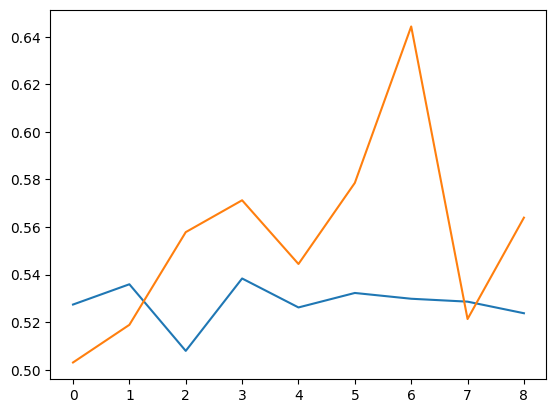

In [21]:
import matplotlib.pyplot as plt
plt.plot(p.accuracy01[98:107].to_numpy().astype(np.float32))
plt.plot(p.accuracy01[120:129].to_numpy().astype(np.float32))